# MATH 210 Introduction to Mathematical Computing

## March 31, 2017

1. Wind data
    * Parsing dates with datetime object
    * Use .map to manipulate a dataframe
    * Use groupby and `.size` to find predominant wind direction
    * Wind speed diurnal patterns
2. Vancouver crime data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Wind data from the Vancouver Airport

Vancouver weather data is available on [Environment Canada's webpage](http://climate.weather.gc.ca/) but it's nicely compiled on [vancouver.weatherstats.ca](https://vancouver.weatherstats.ca/). I downloaded data from July 2011 to today March 31, 2017. Let's take a look!

In [2]:
df = pd.read_csv("weatherstats_vancouver_hourly.csv")

In [3]:
df.head()

,date_time_local,date,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,temperature,windchill,humidex,visibility,health_index,cloud_cover_old,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation
0,2017-03-31 12:00:00 PDT,1490986800,102.85,102.9,E,10.0,20,NaN,73.0,4.8,9.4,NaN,NaN,24100.0,NaN,8.0,NaN,NaN,NaN,NaN
1,2017-03-31 11:00:00 PDT,1490983200,102.85,102.9,ESE,10.0,22,NaN,78.0,5.3,8.9,NaN,NaN,24100.0,2.4,8.0,NaN,NaN,NaN,NaN
2,2017-03-31 10:00:00 PDT,1490979600,102.85,102.9,E,10.0,23,NaN,84.0,5.5,8.0,NaN,NaN,24100.0,2.5,8.0,NaN,NaN,NaN,NaN
3,2017-03-31 09:00:00 PDT,1490976000,102.85,102.9,E,9.0,19,NaN,84.0,5.2,7.7,NaN,NaN,32200.0,2.5,8.0,NaN,8.0,NaN,NaN
4,2017-03-31 08:00:00 PDT,1490972400,102.85,102.9,E,8.0,17,NaN,85.0,4.3,6.6,NaN,NaN,32200.0,2.4,8.0,NaN,8.0,NaN,NaN


### Parsing dates with datetime object

The first column is a date and time and so we should use the pandas DateTime object. We can do this by setting the `parse_dates` parameter in the `read_csv` function to the list with just the one column number 0. Also, let's just focus on wind and temperature and so we use the `usecols` parameter to import just these columns for the `.csv` file.

In [4]:
weather = pd.read_csv("weatherstats_vancouver_hourly.csv",usecols=[0,2,4,6,10],parse_dates=[0])

In [5]:
weather.head()

,date_time_local,pressure_station,wind_dir,wind_speed,temperature
0,2017-03-31 19:00:00,102.85,E,20,9.4
1,2017-03-31 18:00:00,102.85,ESE,22,8.9
2,2017-03-31 17:00:00,102.85,E,23,8.0
3,2017-03-31 16:00:00,102.85,E,19,7.7
4,2017-03-31 15:00:00,102.85,E,17,6.6


In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
date_time_local     50000 non-null datetime64[ns]
pressure_station    50000 non-null float64
wind_dir            49633 non-null object
wind_speed          50000 non-null int64
temperature         50000 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 1.9+ MB


Notice that the first column is now pandas datetime objects. We can think of these as vectors: (Year,Month,Day,Hour,Minute). For example:

In [7]:
pd.datetime?

In [8]:
right_now = pd.datetime(2017,3,31,2,15,0)

In [9]:
type(right_now)

datetime.datetime

In [10]:
right_now.year

2017

In [11]:
right_now.day

31

### Use .map to manipulate a dataframe

The `.map` series method applies a function to each entry in a series. We can use this to extract the year, month and day from the `date_tim_local` column to create new columns. Notice that we are using lambda functions to define functions inline.

In [12]:
weather['Year'] = weather['date_time_local'].map(lambda d : d.year)
weather['Month'] = weather['date_time_local'].map(lambda d : d.month)
weather['Day'] = weather['date_time_local'].map(lambda d : d.day)
weather['Hour'] = weather['date_time_local'].map(lambda d : d.hour)

In [13]:
weather.head()

,date_time_local,pressure_station,wind_dir,wind_speed,temperature,Year,Month,Day,Hour
0,2017-03-31 19:00:00,102.85,E,20,9.4,2017,3,31,19
1,2017-03-31 18:00:00,102.85,ESE,22,8.9,2017,3,31,18
2,2017-03-31 17:00:00,102.85,E,23,8.0,2017,3,31,17
3,2017-03-31 16:00:00,102.85,E,19,7.7,2017,3,31,16
4,2017-03-31 15:00:00,102.85,E,17,6.6,2017,3,31,15


In [14]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
date_time_local     50000 non-null datetime64[ns]
pressure_station    50000 non-null float64
wind_dir            49633 non-null object
wind_speed          50000 non-null int64
temperature         50000 non-null float64
Year                50000 non-null int64
Month               50000 non-null int64
Day                 50000 non-null int64
Hour                50000 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 3.4+ MB


### Use groupby and `.size` to find predominant wind direction

The [groupby](http://pandas.pydata.org/pandas-docs/stable/groupby.html) method is one of the most commonly used and most powerful methods used in pandas. It allows us to group the data by values in specified columns and then do operations on the groups. For example, we can group the data by the wind direction and then count the number of rows using `.size` and then plot the result.

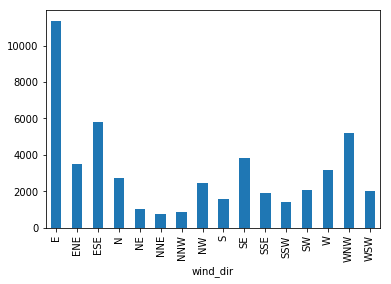

In [15]:
weather.groupby('wind_dir').size().plot(kind='bar')

This is the total numbers of hours since July 2011 that the wind was blowing in each direction. Let's do this month by month.

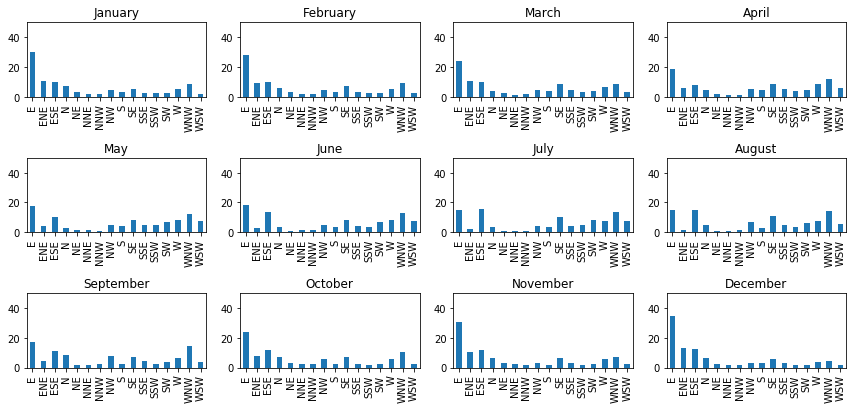

In [16]:
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
plt.figure(figsize=(12,6))
plt.subplot(3,4,1)
for month in range(1,13):
    plt.subplot(3,4,month)
    wind_directions = weather[weather['Month'] == month].groupby('wind_dir').size()
    wind_directions = wind_directions / wind_directions.sum() * 100
    wind_directions.plot(kind='bar')
    plt.tight_layout()
    plt.title(months[month - 1]), plt.xlabel(''), plt.ylim([0,50])

The most common wind direction is towards the East. This makes sense since Vancouver is on the coast and the wind is coming from the ocean.

### Wind speed diurnal patterns

Let's use groupby and `.mean` to see what the average wind speed is by time of day for each month. Patterns that repeat daily are called [diurnal](https://en.wikipedia.org/wiki/Diurnal_temperature_variation).

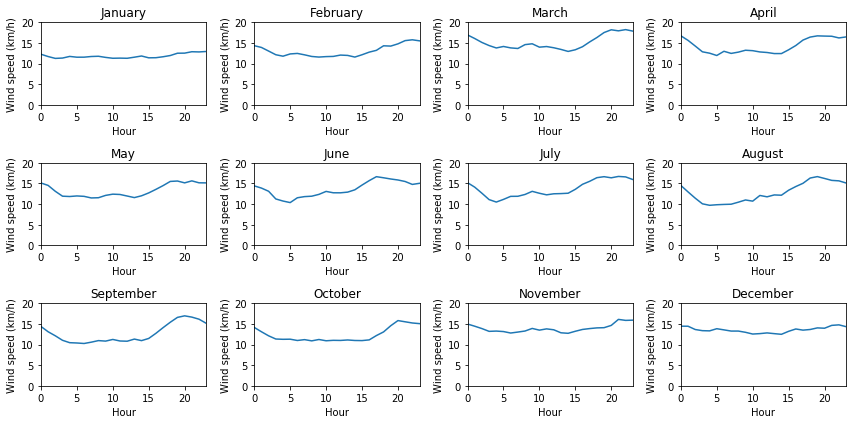

In [17]:
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
plt.figure(figsize=(12,6))
plt.subplot(3,4,1)
for month in range(1,13):
    plt.subplot(3,4,month)
    weather[weather['Month'] == month].groupby('Hour')['wind_speed'].mean().plot()
    plt.tight_layout()
    plt.title(months[month - 1]), plt.xlabel('Hour'), plt.ylabel('Wind speed (km/h)'), plt.ylim([0,20])

## Vancouver Crime Data

The [City of Vancouver Open Data Catalogue](http://vancouver.ca/your-government/open-data-catalogue.aspx) includes crime data. Let's import the most recent dataset and plot the latitude and longitude of each reported crime in the dataset.

In [18]:
crime = pd.read_csv("http://www.math.ubc.ca/~pwalls/data/van_crime.csv")

In [19]:
crime.head()

,TYPE,YEAR,MONTH,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Mischief,2015,3,26XX E 49TH AVE,Victoria-Fraserview,496065.581256,5.452452e+06
1,Theft from Vehicle,2015,12,34XX WILLIAM ST,Hastings-Sunrise,497850.800800,5.457933e+06
2,Theft from Vehicle,2015,4,34XX WILLIAM ST,Hastings-Sunrise,497879.450446,5.457923e+06
3,Theft from Vehicle,2015,10,34XX WILLIAM ST,Hastings-Sunrise,497901.623450,5.457932e+06
4,Theft from Vehicle,2015,9,34XX WILLIAM ST,Hastings-Sunrise,497921.510576,5.457932e+06


In [20]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45802 entries, 0 to 45801
Data columns (total 7 columns):
TYPE             45802 non-null object
YEAR             45802 non-null int64
MONTH            45802 non-null int64
HUNDRED_BLOCK    45802 non-null object
NEIGHBOURHOOD    41815 non-null object
X                45802 non-null float64
Y                45802 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 2.4+ MB


In [21]:
crime['TYPE'].unique()

array(['Mischief', 'Theft from Vehicle', 'Other Theft', 'Theft of Vehicle',
       'Break and Enter Residential/Other', 'Offence Against a Person',
       'Homicide', 'Break and Enter Commercial'], dtype=object)

There are 8 types of crimes reported in the dataset. Notice that the location of the homicides are not included because this is sensitive information that is not made public.

In [22]:
crime[crime['TYPE'] == 'Homicide'].head()

,TYPE,YEAR,MONTH,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
3485,Homicide,2015,3,OFFSET TO PROTECT PRIVACY,NaN,0.0,0.0
3486,Homicide,2015,9,OFFSET TO PROTECT PRIVACY,NaN,0.0,0.0
3488,Homicide,2015,7,OFFSET TO PROTECT PRIVACY,NaN,0.0,0.0
3489,Homicide,2015,7,OFFSET TO PROTECT PRIVACY,NaN,0.0,0.0
3491,Homicide,2015,4,OFFSET TO PROTECT PRIVACY,NaN,0.0,0.0


Let's plot the crime dataset excluding homicides by selecting only the rows with nonzero longitude and latitude. The parameter `s` sets the size of the points and `alpha` is the opacity.

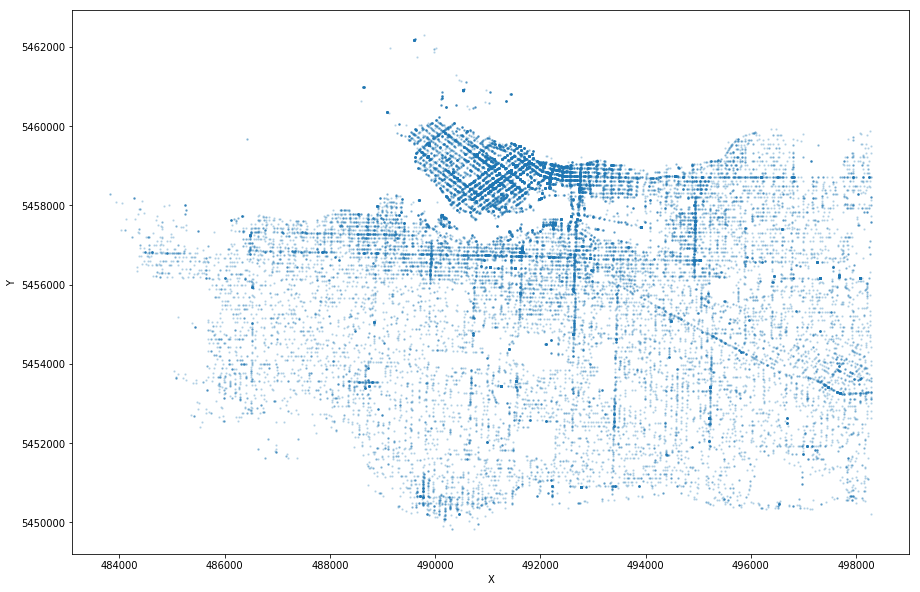

In [23]:
crime[crime['X'] > 0].plot(kind='scatter',x='X',y='Y',alpha=0.2,s=2,figsize=(15,10))